In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")

paths1_df = pd.read_csv("AVMs4b/paths1_results.csv")
paths2_df = pd.read_csv("AVMs4b/paths2_results.csv")

paths1_df.head()

def extract_structure(df):
    """
    Returns:
        b_values: sorted list of block sizes
        var_map: dict {var_idx: [colnames]}
    """
    cols = [c for c in df.columns if c != "file_name"]
    var_map = {1: [], 2: [], 3: [], 4: []}
    b_values = set()

    for c in cols:
        # column format W{i}_{b}
        w, b = c.split("_")
        i = int(w[1])
        b = int(b)
        var_map[i].append(c)
        b_values.add(b)

    b_values = sorted(b_values)
    for k in var_map:
        var_map[k] = sorted(var_map[k], key=lambda x: int(x.split("_")[1]))

    return b_values, var_map


In [26]:
def plot_overlay_grid(df, title):
    b_values, var_map = extract_structure(df)
    palette = sns.color_palette("tab10", len(b_values))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for var_idx in range(1, 5):
        ax = axes[var_idx - 1]
        cols = var_map[var_idx]

        for j, c in enumerate(cols):
            arr = df[c].dropna().values
            b = int(c.split("_")[1])
            sns.kdeplot(arr, ax=ax, label=f"b={b}", color=palette[j], linewidth=1.8)

        ax.set_title(f"W{var_idx}")
        ax.set_xlabel("AVM")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    fig.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


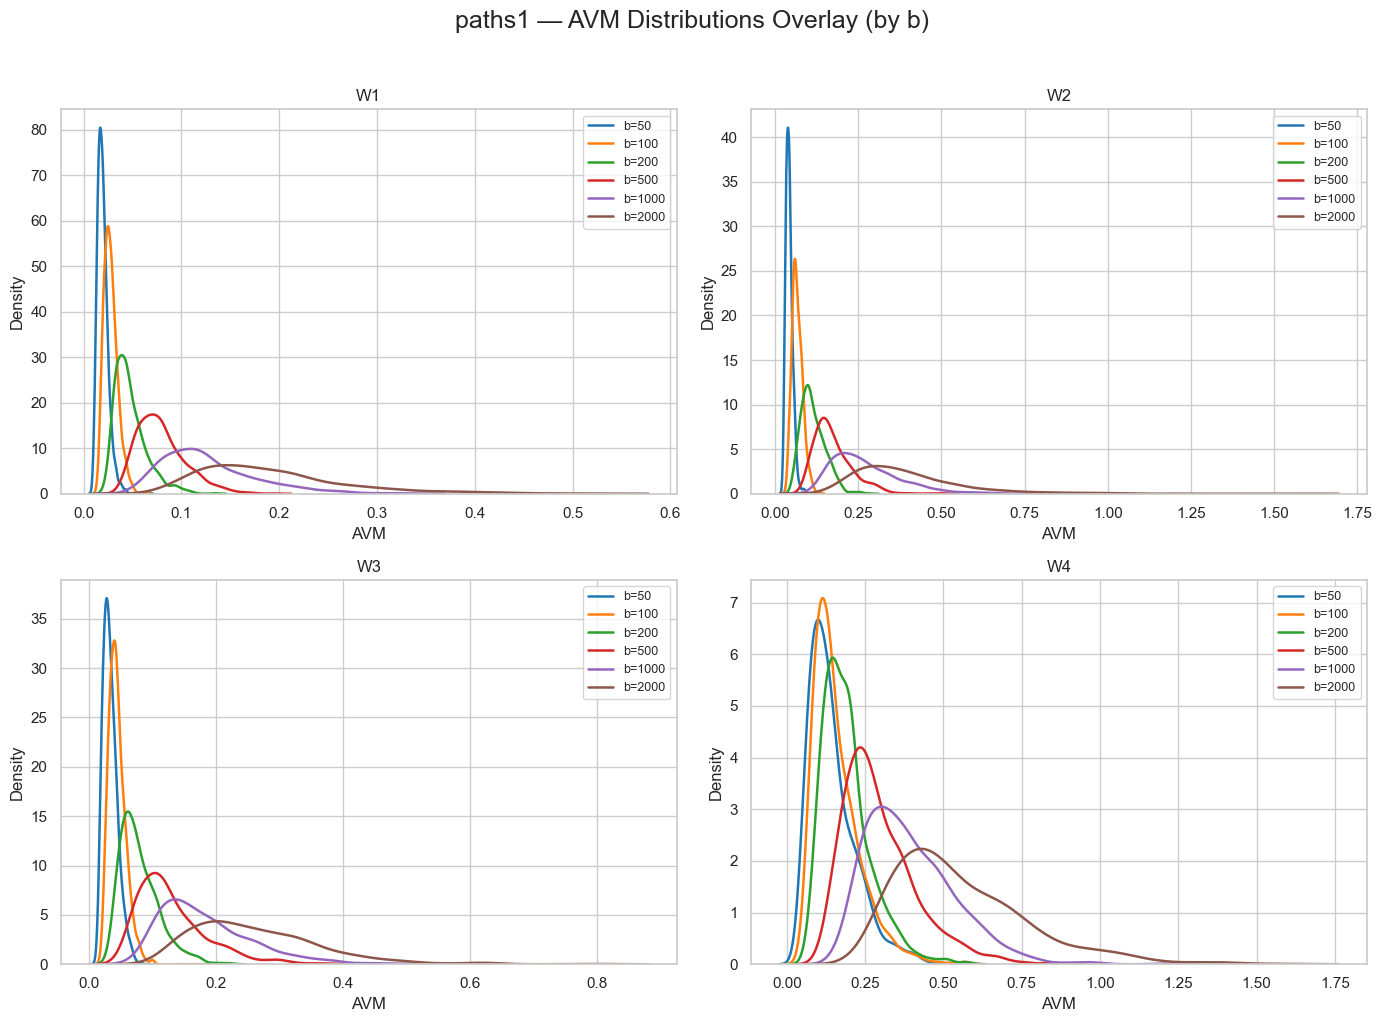

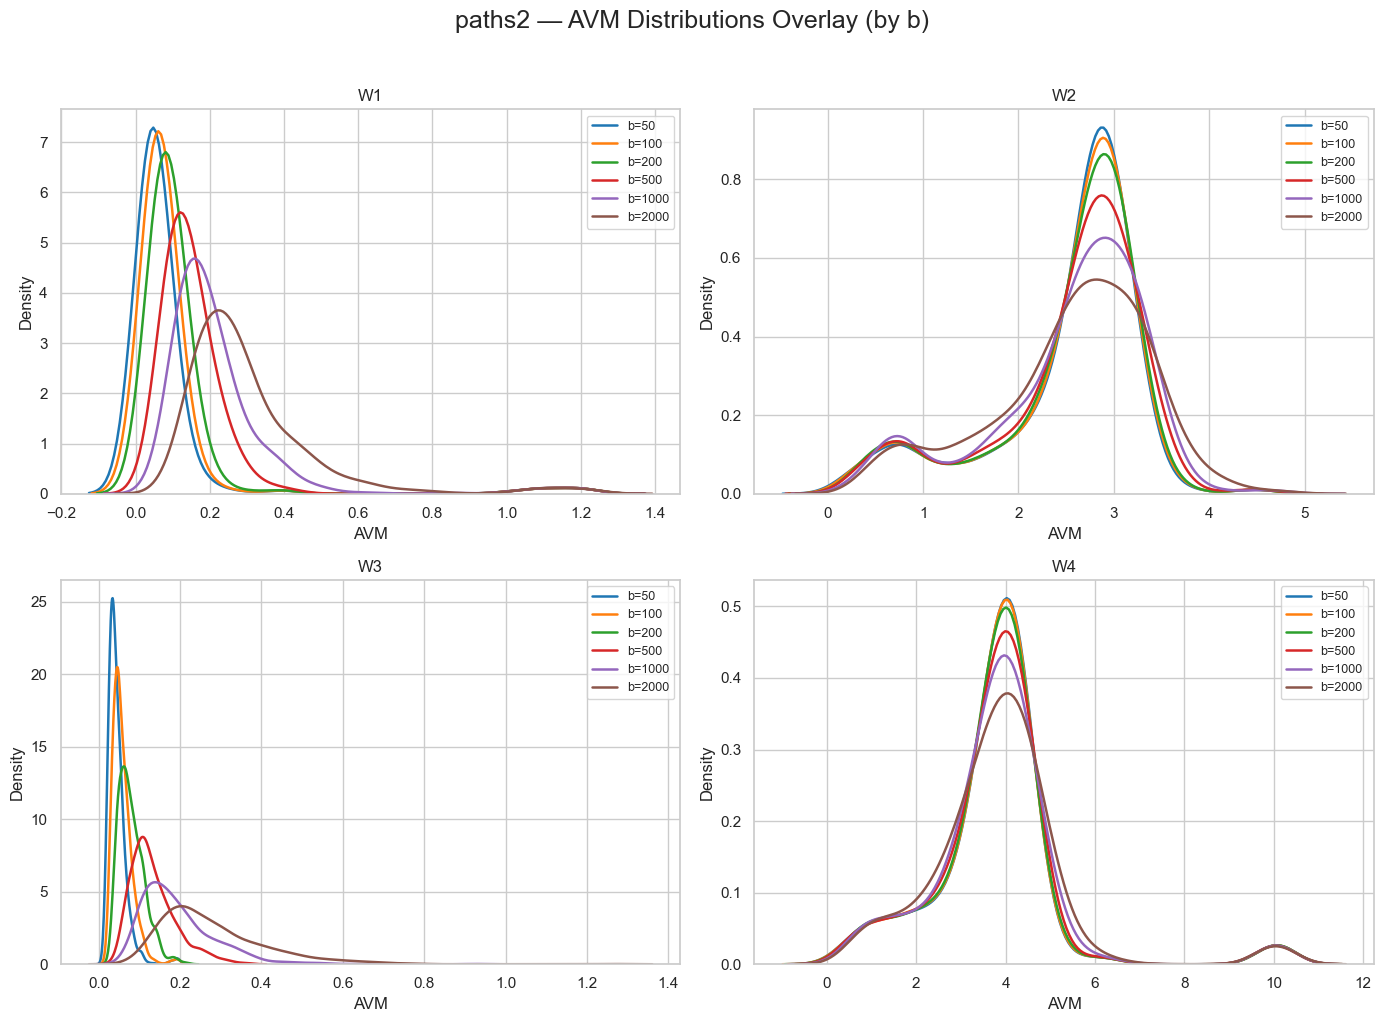

In [27]:
plot_overlay_grid(paths1_df, "paths1 — AVM Distributions Overlay (by b)")
plot_overlay_grid(paths2_df, "paths2 — AVM Distributions Overlay (by b)")


In [28]:
from scipy import stats
import pandas as pd
import numpy as np

def scale_bridge_to_data(bridge_areas, data):
    """
    Scale bridge samples to roughly match the empirical data.
    Uses mean + std scaling (affine).
    """
    m_b, s_b = bridge_areas.mean(), bridge_areas.std()
    m_d, s_d = data.mean(), data.std()

    if s_b == 0 or s_d == 0:
        return bridge_areas * 0 + m_d

    return (bridge_areas - m_b) / s_b * s_d + m_d

def ks_table_against_bridge(df, bridge_areas):
    b_values, var_map = extract_structure(df)

    rows = []

    for var_idx in range(1, 5):
        cols = var_map[var_idx]

        for c in cols:
            arr = df[c].dropna().values
            if len(arr) < 5:
                continue

            b = int(c.split("_")[1])

            scaled_bridge = scale_bridge_to_data(bridge_areas, arr)

            ks_stat, p_val = stats.ks_2samp(arr, scaled_bridge)

            rows.append({
                "W": var_idx,
                "b": b,
                "n_data": len(arr),
                "KS_stat": ks_stat,
                "p_value": p_val
            })

    return pd.DataFrame(rows).sort_values(["W", "b"])

def plot_overlay_grid_with_bridge(df, bridge_areas, title):
    b_values, var_map = extract_structure(df)
    palette = sns.color_palette("tab10", len(b_values))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for var_idx in range(1, 5):
        ax = axes[var_idx - 1]
        cols = var_map[var_idx]

        for j, c in enumerate(cols):
            arr = df[c].dropna().values
            if len(arr) < 5:
                continue

            b = int(c.split("_")[1])

            # empirical KDE
            sns.kdeplot(arr, ax=ax, label=f"b={b}", 
                        color=palette[j], linewidth=2)

            # scaled bridge KDE
            scaled_bridge = scale_bridge_to_data(bridge_areas, arr)
            sns.kdeplot(scaled_bridge, ax=ax, 
                        linestyle="--", color=palette[j], alpha=0.6)

        ax.set_title(f"W{var_idx}")
        ax.set_xlabel("AVM")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    fig.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

def simulate_brownian_bridge_area(n_samples=10000, n_steps=1000):
    """
    Simulates the distribution of the L1-norm (area under absolute curve)
    of a Brownian Bridge.
    
    Args:
        n_samples (int): Number of trajectories to simulate.
        n_steps (int): Number of time steps per trajectory (discretization).
        
    Returns:
        areas (np.array): Array of calculated areas (W-1 distances).
    """
    # 1. Generate standard Brownian Motion: W(t)
    dt = 1.0 / n_steps
    
    # Generate random increments: dW ~ N(0, dt)
    # Shape: (n_samples, n_steps)
    dW = np.sqrt(dt) * np.random.randn(n_samples, n_steps)
    
    # Cumulative sum to get Brownian Motion path W(t)
    # We prepend a column of zeros so paths start at 0
    W = np.cumsum(dW, axis=1)
    W = np.hstack([np.zeros((n_samples, 1)), W])
    
    # Time vector t from 0 to 1
    t = np.linspace(0, 1, n_steps + 1)
    
    # 2. Convert to Brownian Bridge: B_bridge(t)
    # Formula: B(t) = W(t) - t * W(1)
    # W[:, -1] is W(1) for each path (shape: n_samples)
    W_at_1 = W[:, -1][:, np.newaxis] # Reshape for broadcasting
    
    B_bridge = W - (t * W_at_1)
    
    # 3. Calculate Area: Integral of |B(t)| dt
    # Using trapezoidal rule for numerical integration
    areas = np.trapz(np.abs(B_bridge), dx=dt, axis=1)
    
    return areas

    W     b  n_data  KS_stat   p_value
0   1    50    1000  0.03910  0.097310
1   1   100    1000  0.05002  0.014325
2   1   200    1000  0.02070  0.786975
3   1   500    1000  0.03708  0.131739
4   1  1000    1000  0.02782  0.426445
5   1  2000    1000  0.02272  0.683636
6   2    50    1000  0.04542  0.033996
7   2   100    1000  0.05628  0.003866
8   2   200    1000  0.04248  0.056544
9   2   500    1000  0.02532  0.547561
10  2  1000    1000  0.02080  0.782076
11  2  2000    1000  0.02788  0.423727
12  3    50    1000  0.03600  0.153873
13  3   100    1000  0.04488  0.037421
14  3   200    1000  0.01844  0.886601
15  3   500    1000  0.02616  0.505313
16  3  1000    1000  0.01926  0.853308
17  3  2000    1000  0.03684  0.136420
18  4    50    1000  0.02154  0.744964
19  4   100    1000  0.02768  0.432825
20  4   200    1000  0.03578  0.158728
21  4   500    1000  0.01678  0.941038
22  4  1000    1000  0.03750  0.123863
23  4  2000    1000  0.02100  0.772189


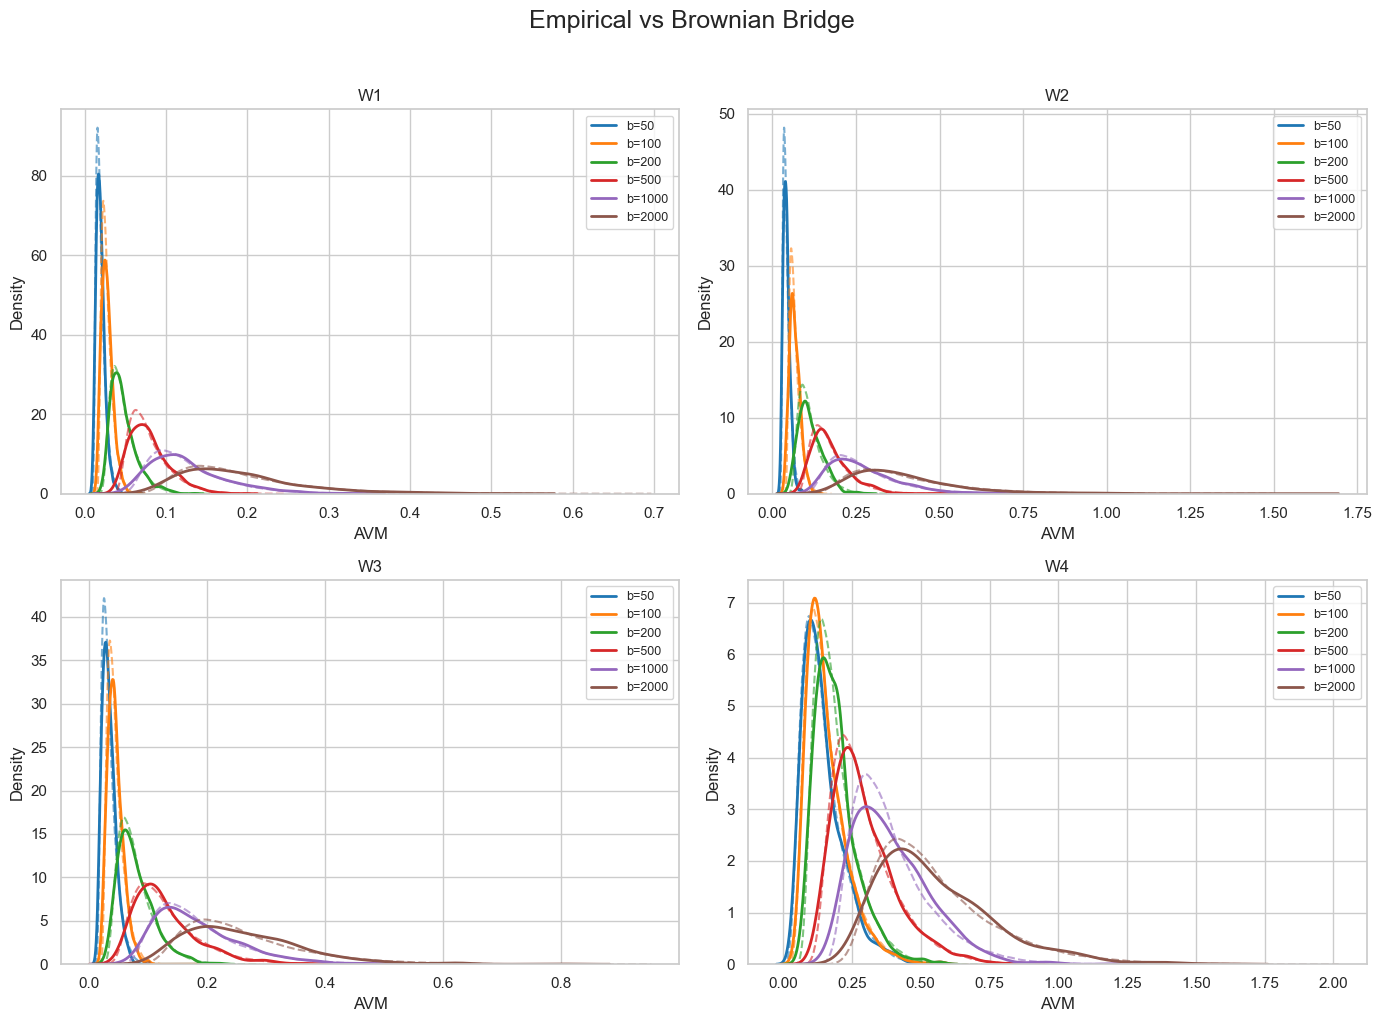

In [30]:
# 1. simulate bridge once
N_SAMPLES = 50000
bridge_areas = simulate_brownian_bridge_area(n_samples=N_SAMPLES)

# 2. table
ks_df = ks_table_against_bridge(paths1_df, bridge_areas)
print(ks_df)

# 3. plots
plot_overlay_grid_with_bridge(paths1_df, bridge_areas, "Empirical vs Brownian Bridge")


    W     b  n_data  KS_stat        p_value
0   1    50    1000  0.42560  1.345999e-161
1   1   100    1000  0.40432  3.207977e-145
2   1   200    1000  0.37562  1.091493e-124
3   1   500    1000  0.28670   8.464932e-72
4   1  1000    1000  0.21018   1.848883e-38
5   1  2000    1000  0.11480   1.044496e-11
6   2    50    1000  0.29334   3.283995e-75
7   2   100    1000  0.28926   4.192407e-73
8   2   200    1000  0.27618   1.444751e-66
9   2   500    1000  0.25420   2.611604e-56
10  2  1000    1000  0.22976   5.833100e-46
11  2  2000    1000  0.18798   8.574015e-31
12  3    50    1000  0.07404   4.060810e-05
13  3   100    1000  0.03450   1.894399e-01
14  3   200    1000  0.03664   1.404226e-01
15  3   500    1000  0.02772   4.309965e-01
16  3  1000    1000  0.02424   6.035152e-01
17  3  2000    1000  0.01554   9.690262e-01
18  4    50    1000  0.22310   2.486856e-43
19  4   100    1000  0.22244   4.485873e-43
20  4   200    1000  0.21322   1.405983e-39
21  4   500    1000  0.20260   9

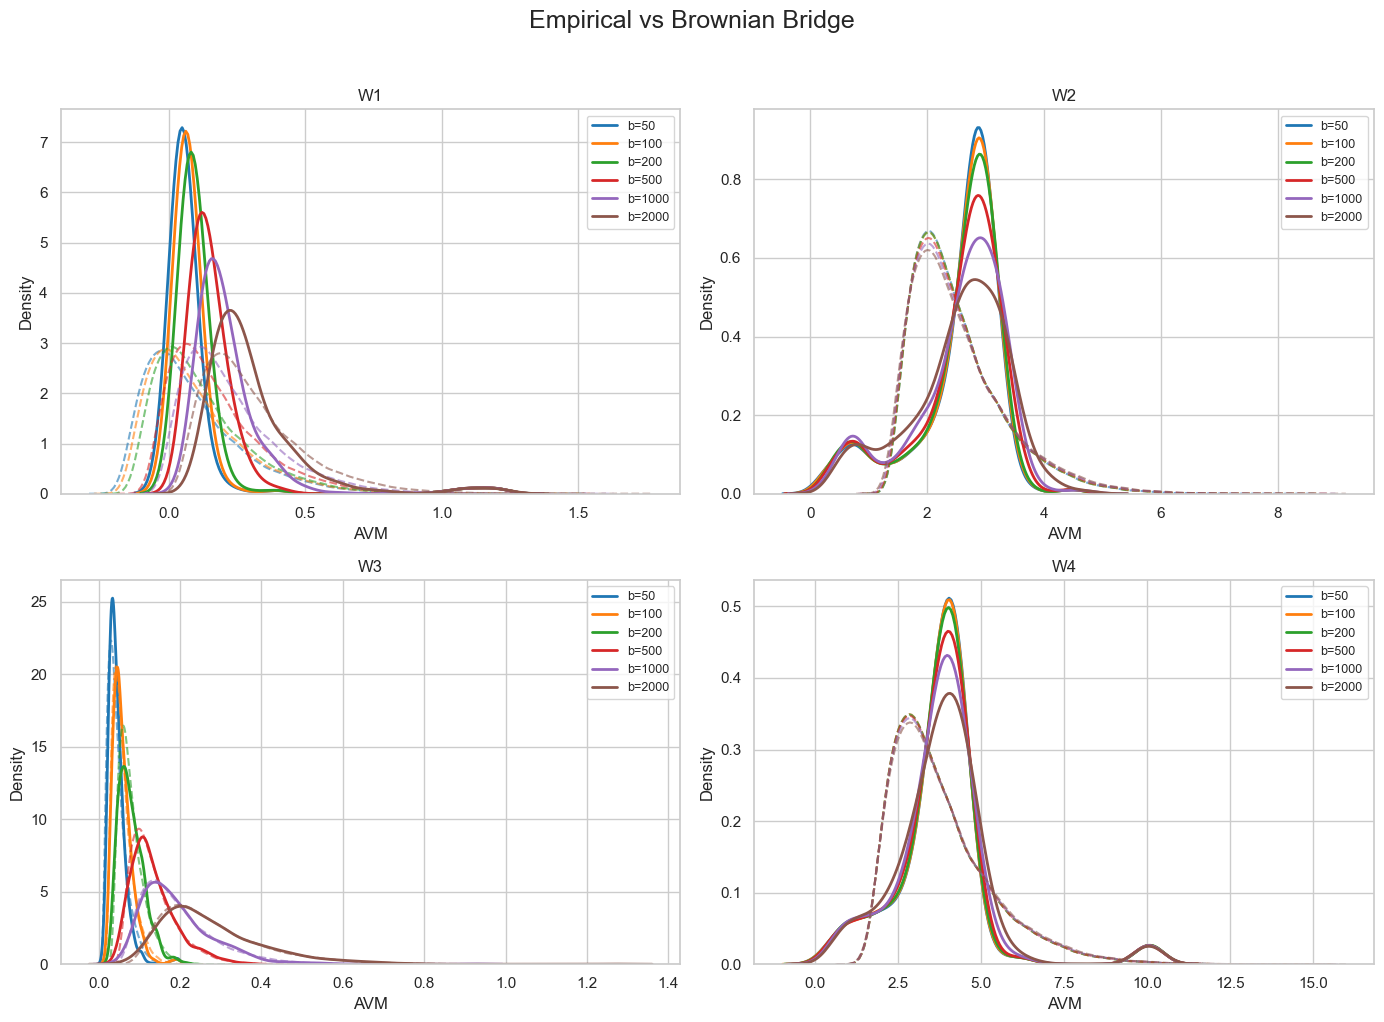

In [31]:
# 1. simulate bridge once
N_SAMPLES = 50000
bridge_areas = simulate_brownian_bridge_area(n_samples=N_SAMPLES)

# 2. table
ks_df = ks_table_against_bridge(paths2_df, bridge_areas)
print(ks_df)

# 3. plots
plot_overlay_grid_with_bridge(paths2_df, bridge_areas, "Empirical vs Brownian Bridge")


In [32]:
from scipy import stats
import numpy as np
import pandas as pd

# --- NEW: simulate the LIMIT law  ∫ |B(F(t))| dt  via  ∫_0^1 |B(u)| dQ(u) ---
# If F has quantile Q, then ∫ |B(F(t))| dt = ∫_0^1 |B(u)| dQ(u).
# With a scipy "frozen" distribution dist (supports .ppf), we approximate this integral
# by trapezoidal integration of |B(u)| against x = Q(u).

def simulate_bridge_area_composed_with_F(dist, n_samples=10000, n_u=2000, eps=1e-6, rng=None):
    """
    Simulate samples from the limit distribution:
        A = ∫_{-∞}^{∞} |B(F(t))| dt  =  ∫_0^1 |B(u)| dQ(u),
    where B is a standard Brownian bridge and Q is the quantile function of F.

    Args:
        dist: scipy.stats frozen distribution (must implement dist.ppf(u))
        n_samples: number of bridge paths
        n_u: grid size on (0,1) for u
        eps: avoid u=0,1 where ppf can be infinite
        rng: np.random.Generator or None

    Returns:
        areas: (n_samples,) array of simulated areas
    """
    if rng is None:
        rng = np.random.default_rng()

    # u-grid in (0,1)
    u = np.linspace(eps, 1 - eps, n_u)

    # Quantile grid (x-axis for Stieltjes integral)
    Q = dist.ppf(u)
    Q = np.asarray(Q, dtype=float)

    # Guard against infinities / NaNs from ppf
    finite = np.isfinite(Q)
    if finite.sum() < 10:
        raise ValueError("dist.ppf(u) produced too many non-finite values; choose another dist or increase eps.")
    u = u[finite]
    Q = Q[finite]

    # Simulate Brownian bridge on u-grid:
    # Construct Brownian motion increments over u, then bridge it.
    du = np.diff(u)
    # Brownian motion W(u): W(0)=0, increments ~ N(0, du)
    dW = rng.normal(loc=0.0, scale=np.sqrt(du), size=(n_samples, du.size))
    W = np.concatenate([np.zeros((n_samples, 1)), np.cumsum(dW, axis=1)], axis=1)

    # Brownian bridge: B(u) = W(u) - u*W(1)   (here "1" corresponds to last grid point u[-1])
    W_end = W[:, -1][:, None]
    B = W - (u[None, :] * W_end)

    # Compute ∫ |B(u)| dQ(u) numerically:
    # Approximate by trapezoid with x-axis = Q(u)
    areas = np.trapz(np.abs(B), x=Q, axis=1)
    return areas


# --- OPTIONAL: choose how to approximate F for each data column ---
def fit_F_from_data(arr, family="norm"):
    """
    Return a scipy frozen distribution approximating F for this column.
    'norm' is the simplest; you can swap to 't', 'logistic', etc.
    """
    arr = np.asarray(arr)
    if family == "norm":
        mu, sigma = stats.norm.fit(arr)
        sigma = max(sigma, 1e-12)
        return stats.norm(loc=mu, scale=sigma)
    if family == "t":
        df, loc, scale = stats.t.fit(arr)
        scale = max(scale, 1e-12)
        return stats.t(df, loc=loc, scale=scale)
    raise ValueError(f"Unknown family={family!r}")


# --- Your existing scaling helper (kept as-is) ---
def scale_bridge_to_data(bridge_areas, data):
    m_b, s_b = bridge_areas.mean(), bridge_areas.std()
    m_d, s_d = data.mean(), data.std()
    if s_b == 0 or s_d == 0:
        return bridge_areas * 0 + m_d
    return (bridge_areas - m_b) / s_b * s_d + m_d


# --- REWRITE: now compare against the *F-dependent* limit law per column ---
def ks_table_against_B_of_F(df, n_samples=10000, n_u=2000, family="norm", do_affine_scale=True, seed=0):
    b_values, var_map = extract_structure(df)
    rng = np.random.default_rng(seed)

    rows = []
    cache = {}  # cache by (family, colname) or by fitted params if you prefer

    for var_idx in range(1, 5):
        cols = var_map[var_idx]

        for c in cols:
            arr = df[c].dropna().values
            if len(arr) < 5:
                continue

            b = int(c.split("_")[1])

            # Fit F (parametric) for THIS column
            dist = fit_F_from_data(arr, family=family)

            # Simulate limit areas for this F (cache to avoid resimulating)
            key = (family, c)
            if key not in cache:
                cache[key] = simulate_bridge_area_composed_with_F(
                    dist, n_samples=n_samples, n_u=n_u, rng=rng
                )
            bridge_areas_F = cache[key]

            # Optional: keep your affine scaling (often unnecessary now, but you asked to "rewrite")
            comp = scale_bridge_to_data(bridge_areas_F, arr) if do_affine_scale else bridge_areas_F

            ks_stat, p_val = stats.ks_2samp(arr, comp)

            rows.append({
                "W": var_idx,
                "b": b,
                "n_data": len(arr),
                "F_fit": family,
                "KS_stat": ks_stat,
                "p_value": p_val
            })

    return pd.DataFrame(rows).sort_values(["W", "b"])


# --- If you also want the overlay plot, same idea: simulate per column via B∘F ---
def plot_overlay_grid_with_B_of_F(df, title, n_samples=10000, n_u=2000, family="norm", do_affine_scale=True, seed=0):
    import matplotlib.pyplot as plt
    import seaborn as sns

    b_values, var_map = extract_structure(df)
    palette = sns.color_palette("tab10", len(b_values))
    rng = np.random.default_rng(seed)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    cache = {}

    for var_idx in range(1, 5):
        ax = axes[var_idx - 1]
        cols = var_map[var_idx]

        for j, c in enumerate(cols):
            arr = df[c].dropna().values
            if len(arr) < 5:
                continue

            b = int(c.split("_")[1])

            # empirical KDE
            sns.kdeplot(arr, ax=ax, label=f"b={b}", color=palette[j], linewidth=2)

            # simulate limit areas for fitted F
            dist = fit_F_from_data(arr, family=family)
            key = (family, c)
            if key not in cache:
                cache[key] = simulate_bridge_area_composed_with_F(
                    dist, n_samples=n_samples, n_u=n_u, rng=rng
                )
            bridge_areas_F = cache[key]

            comp = scale_bridge_to_data(bridge_areas_F, arr) if do_affine_scale else bridge_areas_F
            sns.kdeplot(comp, ax=ax, linestyle="--", color=palette[j], alpha=0.6)

        ax.set_title(f"W{var_idx}")
        ax.set_xlabel("AVM")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    fig.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


    W     b  n_data F_fit  KS_stat   p_value
0   1    50    1000  norm  0.02694  0.467409
1   1   100    1000  norm  0.03462  0.186377
2   1   200    1000  norm  0.03286  0.235325
3   1   500    1000  norm  0.02708  0.460758
4   1  1000    1000  norm  0.02510  0.558832
5   1  2000    1000  norm  0.01858  0.881189
6   2    50    1000  norm  0.03354  0.215373
7   2   100    1000  norm  0.04300  0.051806
8   2   200    1000  norm  0.02940  0.358298
9   2   500    1000  norm  0.02472  0.578466
10  2  1000    1000  norm  0.02080  0.782076
11  2  2000    1000  norm  0.03600  0.153873
12  3    50    1000  norm  0.02672  0.477957
13  3   100    1000  norm  0.03462  0.186377
14  3   200    1000  norm  0.02482  0.573281
15  3   500    1000  norm  0.03508  0.174992
16  3  1000    1000  norm  0.02496  0.566043
17  3  2000    1000  norm  0.02670  0.478921
18  4    50    1000  norm  0.03444  0.190986
19  4   100    1000  norm  0.04348  0.047740
20  4   200    1000  norm  0.02900  0.374861
21  4   50

/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_55347/3286582159.py:179: UserWarning: Glyph 8728 (\N{RING OPERATOR}) missing from current font.
  plt.tight_layout()
/Users/alexanderyordanov/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8728 (\N{RING OPERATOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


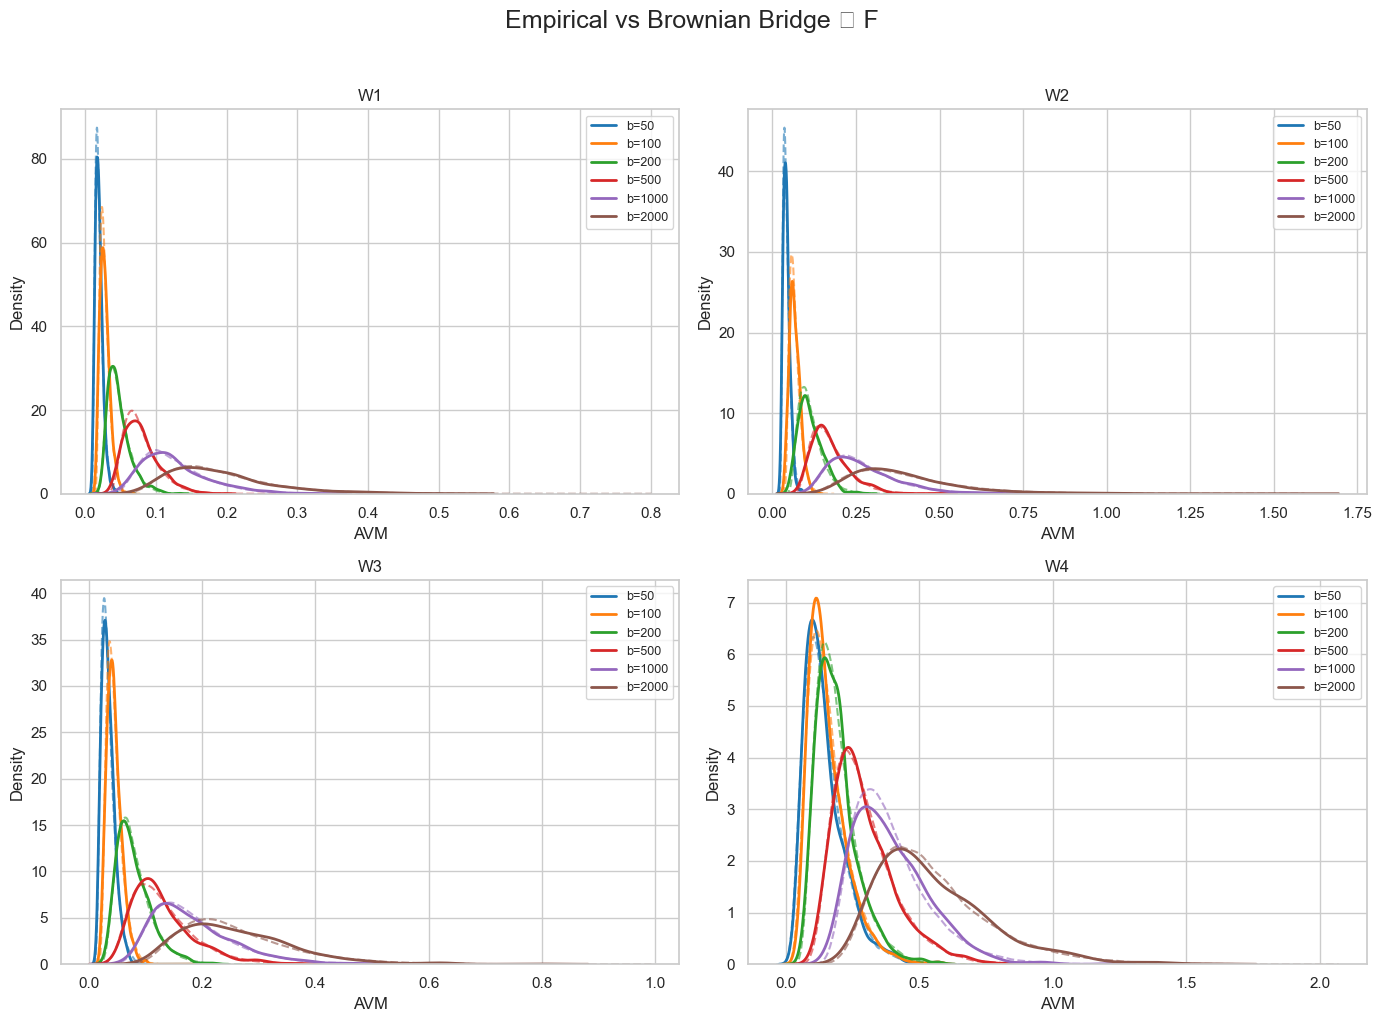

In [33]:
# Parameters
N_SAMPLES = 50000     # number of bridge paths per column
N_U = 2000            # discretization of u in (0,1)
F_FAMILY = "norm"     # or "t", etc.

# 1. KS table against B(F(t))
ks_df = ks_table_against_B_of_F(
    paths1_df,
    n_samples=N_SAMPLES,
    n_u=N_U,
    family=F_FAMILY,
    do_affine_scale=True,   # keep same behavior as before
    seed=42
)

print(ks_df)


# 2. Plots: empirical vs B(F(t))
plot_overlay_grid_with_B_of_F(
    paths1_df,
    title="Empirical vs Brownian Bridge ∘ F",
    n_samples=N_SAMPLES,
    n_u=N_U,
    family=F_FAMILY,
    do_affine_scale=True,
    seed=42
)


    W     b  n_data F_fit  KS_stat        p_value
0   1    50    1000  norm  0.41398  1.569480e-152
1   1   100    1000  norm  0.39362  2.327266e-137
2   1   200    1000  norm  0.36616  2.655709e-118
3   1   500    1000  norm  0.28002   1.880832e-68
4   1  1000    1000  norm  0.20756   1.651347e-37
5   1  2000    1000  norm  0.12308   2.135953e-13
6   2    50    1000  norm  0.27978   2.471784e-68
7   2   100    1000  norm  0.27580   2.212343e-66
8   2   200    1000  norm  0.26166   1.089639e-59
9   2   500    1000  norm  0.23978   4.532113e-50
10  2  1000    1000  norm  0.21524   2.484408e-40
11  2  2000    1000  norm  0.17330   3.298847e-26
12  3    50    1000  norm  0.08194   3.587480e-06
13  3   100    1000  norm  0.03790   1.167233e-01
14  3   200    1000  norm  0.03040   3.190084e-01
15  3   500    1000  norm  0.02550   5.383982e-01
16  3  1000    1000  norm  0.03772   1.198930e-01
17  3  2000    1000  norm  0.02776   4.291725e-01
18  4    50    1000  norm  0.20902   4.891723e-38


/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_55347/3286582159.py:179: UserWarning: Glyph 8728 (\N{RING OPERATOR}) missing from current font.
  plt.tight_layout()
/Users/alexanderyordanov/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8728 (\N{RING OPERATOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


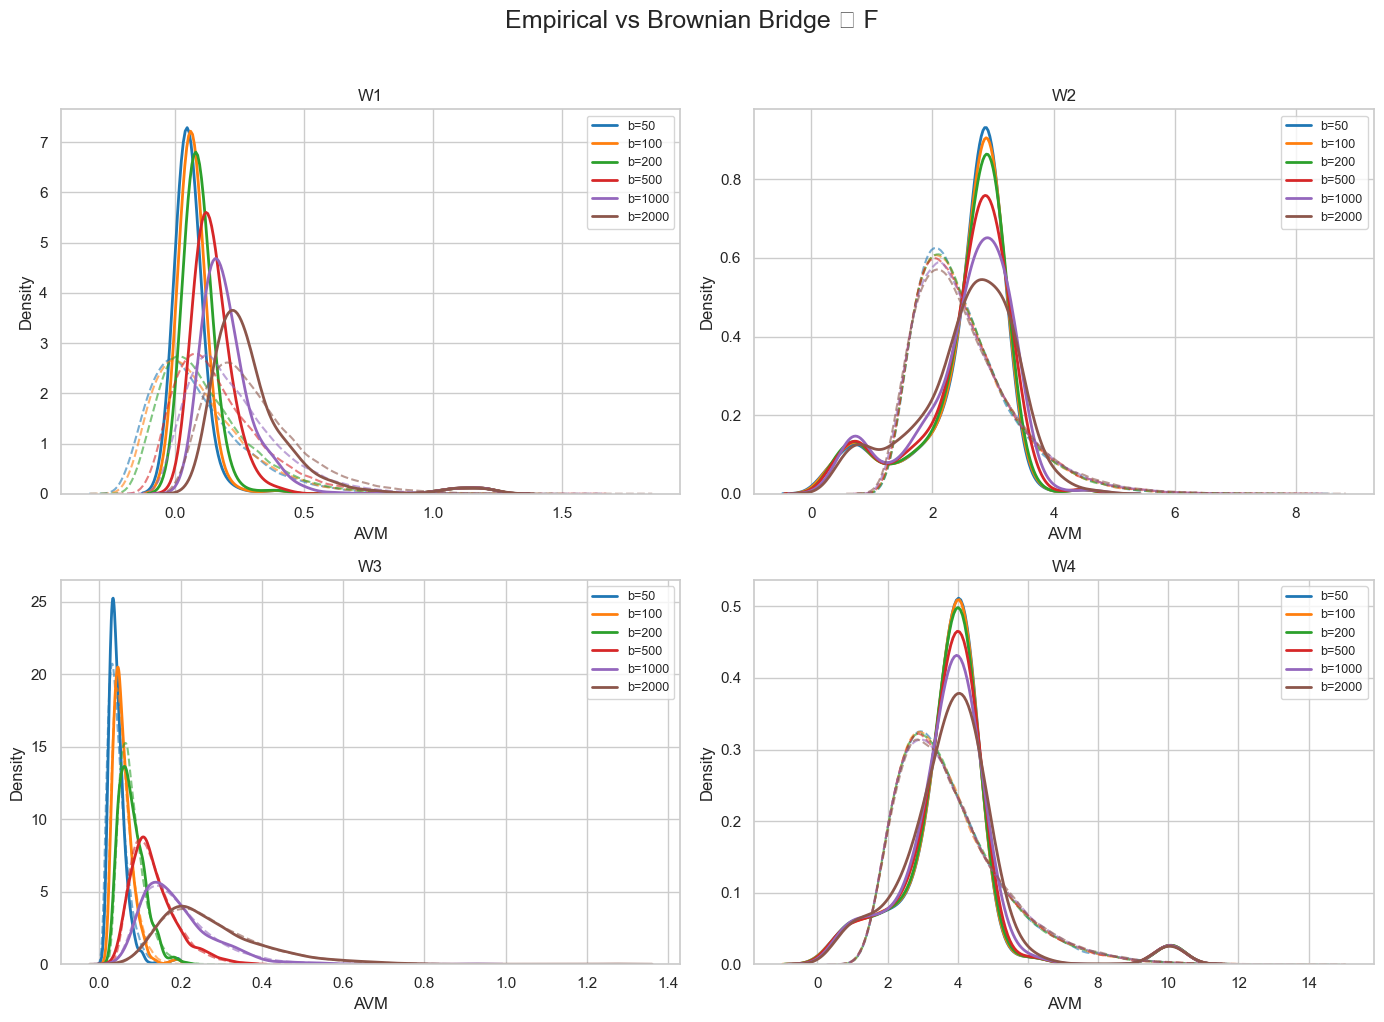

In [34]:
# Parameters
N_SAMPLES = 50000     # number of bridge paths per column
N_U = 2000            # discretization of u in (0,1)
F_FAMILY = "norm"     # or "t", etc.

# 1. KS table against B(F(t))
ks_df = ks_table_against_B_of_F(
    paths2_df,
    n_samples=N_SAMPLES,
    n_u=N_U,
    family=F_FAMILY,
    do_affine_scale=True,   # keep same behavior as before
    seed=42
)

print(ks_df)


# 2. Plots: empirical vs B(F(t))
plot_overlay_grid_with_B_of_F(
    paths2_df,
    title="Empirical vs Brownian Bridge ∘ F",
    n_samples=N_SAMPLES,
    n_u=N_U,
    family=F_FAMILY,
    do_affine_scale=True,
    seed=42
)
